# Imports

In [1]:
from task_1 import *
from task_2 import *

%reload_ext autoreload
%autoreload 2

# Part One

In [2]:
nonlinear_vectorfield_x0 = read_data("./data/nonlinear_vectorfield_data_x0.txt")
nonlinear_vectorfield_x1 = read_data("./data/nonlinear_vectorfield_data_x1.txt")

In [3]:
# Create a list of time step variable and find the one that causes the least mse-error in the x1 approximation
# Approximate the linear vectorfield by a 2x2 matrix A
dt_list = np.arange(0.05, 0.5, 0.05)
err_list, dt, min_index, A_t = search_for_optimal_dt(dt_list, nonlinear_vectorfield_x0, nonlinear_vectorfield_x1)
print("The chosen timestep is:", dt)
print("MSE between all the approximated and known end points for our chosen timestep is:", round(err_list[min_index], 5))

The chosen timestep is: 0.1
MSE between all the approximated and known end points for our chosen timestep is: 0.03728


# Part Two

0.04225101877314505


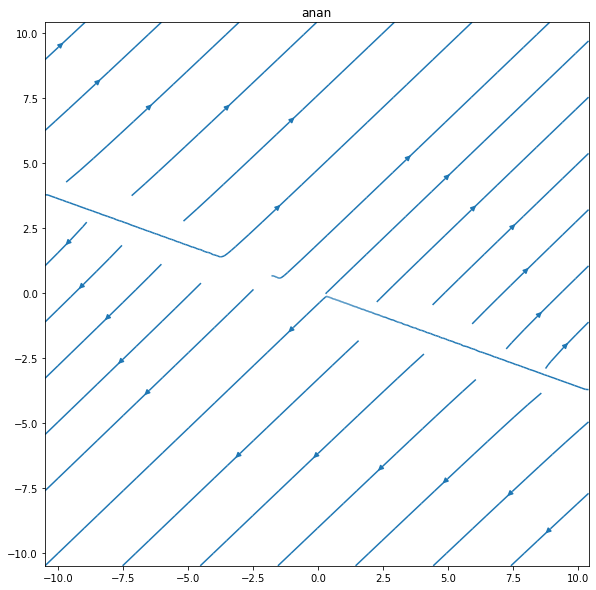

In [11]:
x_l_list = np.linspace((np.min(nonlinear_vectorfield_x0[:, 0]), np.min(nonlinear_vectorfield_x0[:, 1])),
                       (np.max(nonlinear_vectorfield_x0[:, 0]), np.max(nonlinear_vectorfield_x0[:, 1])),
                        500)
distance = np.linalg.norm(nonlinear_vectorfield_x0[:, None] - x_l_list[None], axis=-1)
eps = 0.05 * np.max(distance)
v_k = (nonlinear_vectorfield_x1 - nonlinear_vectorfield_x0) / dt
phi_l_list = get_radial_basis_function(x_l_list, nonlinear_vectorfield_x0, eps)
coefficients = np.linalg.lstsq(phi_l_list, v_k, rcond=1e-2)[0]

f_hat = np.zeros(nonlinear_vectorfield_x0.shape)
for i in range(nonlinear_vectorfield_x0.shape[0]):
    f_hat[i, :] = solve_ivp(lambda t, x: phi_l_list[i, :] @ coefficients, t_span=(0.0, 0.1), t_eval=[0.1], y0=nonlinear_vectorfield_x0[i, :]).y.T

print(mse(nonlinear_vectorfield_x1, f_hat))

Y, X = np.mgrid[-10.5:10.5:0.1, -10.5:10.5:0.1]
plot_phase_portrait_and_trajectory(coefficients, X, Y, "anan")

# Part Three

In [14]:
f_hat = np.zeros(nonlinear_vectorfield_x0.shape)
for i in range(nonlinear_vectorfield_x0.shape[0]):
    f_hat[i, :] = solve_ivp(lambda t, x: phi_l_list[i, :] @ coefficients, t_span=(0.0, 100.0), t_eval=[100.0], y0=nonlinear_vectorfield_x0[i, :]).y.T